# Experimenting with Brittle Star Morphology and Environment

In [1]:
import sys

print(sys.executable)

/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/bin/python


In [4]:
import biorobot

In [5]:
import os
import subprocess
import logging

try:
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
                'Cannot communicate with GPU. '
                'Make sure you are using a GPU Colab runtime. '
                'Go to the Runtime menu and select Choose runtime type.'
                )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write(
                    """{
                            "file_format_version" : "1.0.0",
                            "ICD" : {
                                "library_path" : "libEGL_nvidia.so.0"
                            }
                        }
                        """
                    )

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print('Setting environment variable to use GPU rendering:')
    %env MUJOCO_GL=egl

    # Check if jax finds the GPU
    import jax

    print(jax.devices('gpu'))
except Exception:
    logging.warning("Failed to initialize GPU. Everything will run on the cpu.")

try:
    print('Checking that the mujoco installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".'
            )

print('MuJoCo installation successful.')

Checking that the mujoco installation succeeded:
MuJoCo installation successful.


In [4]:
from mujoco_utils.environment.base import MuJoCoEnvironmentConfiguration
from mujoco_utils.mjcf_utils import MJCFRootComponent
import numpy as np
import jax.numpy as jnp
from typing import Union, List

# Graphics and plotting.
print('Installing mediapy:')
ffmpeg_v = !command -v ffmpeg
assert "command not found" not in ffmpeg_v, f"Please install FFmpeg for visualizations."
!{sys.executable} -m pip install -q mediapy
import mediapy as media

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)
jnp.set_printoptions(precision=3, suppress=True, linewidth=100)

def visualize_mjcf(
        mjcf: MJCFRootComponent
        ) -> None:
    model = mujoco.MjModel.from_xml_string(mjcf.get_mjcf_str())
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model)
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)
    media.show_image(renderer.render())


def post_environment_render(
        render_output: Union[np.ndarray, List[np.ndarray]],
        environment_configuration: MuJoCoEnvironmentConfiguration
        ) -> np.ndarray:
    if len(environment_configuration.camera_ids) > 1:
        render_output = [np.concatenate(env_frames, axis=1) for env_frames in render_output]

    return render_output[:, :, ::-1]  # RGB to BGR

Installing mediapy:


## 1) creating morphology

In [5]:
from mujoco_utils.environment.mjx_env import MJXGymEnvWrapper
import gymnasium
from brb.brittle_star.mjcf.morphology.specification.default import default_brittle_star_morphology_specification
from brb.brittle_star.mjcf.morphology.morphology import MJCFBrittleStarMorphology
from brb.brittle_star.mjcf.morphology.specification.specification import BrittleStarMorphologySpecification


def create_morphology(
        morphology_specification: BrittleStarMorphologySpecification
        ) -> MJCFBrittleStarMorphology:
    morphology = MJCFBrittleStarMorphology(
            specification=morphology_specification
            )
    return morphology


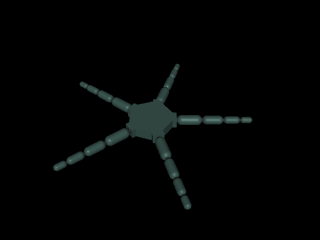

In [6]:
morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=4, use_p_control=True, use_torque_control=False
        )
morphology = create_morphology(morphology_specification=morphology_specification)
visualize_mjcf(mjcf=morphology)


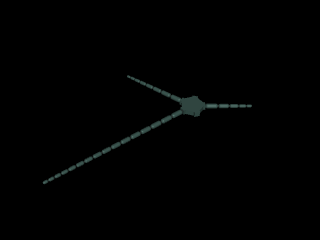

In [7]:
morphology_specification = default_brittle_star_morphology_specification(
        num_arms=4, num_segments_per_arm=[5,0,8,16], use_p_control=True, use_torque_control=False
        )
morphology = create_morphology(morphology_specification=morphology_specification)
visualize_mjcf(mjcf=morphology)


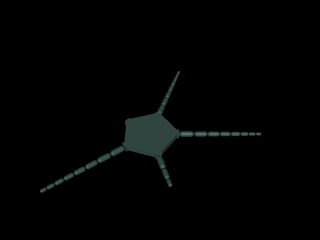

In [8]:
# try some more manual morphology specification:
# the only thing that actually changes is the disk radius in this setting, something we needn't change afterwards
from brb.brittle_star.mjcf.morphology.specification.specification import BrittleStarActuationSpecification, \
    BrittleStarArmSegmentSpecification, BrittleStarArmSpecification, BrittleStarDiskSpecification, \
    BrittleStarJointSpecification, BrittleStarMorphologySpecification
from brb.brittle_star.mjcf.morphology.specification.default import default_arm_specification

num_arms = 5
num_segments_per_arm = [8,8,0,8,3]
disk_specification = BrittleStarDiskSpecification(diameter=0.5, height=0.025)
arm_specifications = list()
for num_segments in num_segments_per_arm:
    arm_specification = default_arm_specification(num_segments_per_arm=num_segments)
    arm_specifications.append(arm_specification)

actuation_specification = BrittleStarActuationSpecification(use_p_control=True, use_torque_control=False)
morphology_specification = BrittleStarMorphologySpecification(
    disk_specification=disk_specification,
    arm_specifications=arm_specifications,
    actuation_specification=actuation_specification)
    

# morphology_specification = default_brittle_star_morphology_specification(
#         num_arms=3, num_segments_per_arm=[5,8,16], use_p_control=True, use_torque_control=False
#         )
morphology = create_morphology(morphology_specification=morphology_specification)
visualize_mjcf(mjcf=morphology)

In [42]:
from brb.brittle_star.mjcf.morphology.specification.default import default_arm_length_based_brittle_star_morphology_specification
# try class default_arm_length_based_brittle_star_morphology_specification
# arm lengths in disc diameter: enter a float: the length of the arm is that float * disc diameter
# the number of segments will always be a multiple of 3 (min 3, max 99)
# Will try by force all different lengths of arms and look which one is closest to the target length


# # LISTS NOT YET SUPPORTED AS ARM LENGTHS
# morphology_specification = default_arm_length_based_brittle_star_morphology_specification(
#         num_arms=5, arm_length_in_disk_diameters=[3,5,5, 0,8], use_p_control=True, use_torque_control=False
#         )

morphology_specification = default_arm_length_based_brittle_star_morphology_specification(
        num_arms=5, arm_length_in_disk_diameters=3, use_p_control=True, use_torque_control=False
        )


morphology = create_morphology(morphology_specification=morphology_specification)
visualize_mjcf(mjcf=morphology)

TypeError: object of type 'numpy.int64' has no len()

In [9]:
num_segments = np.argmin([5,3,2,8,7,9]) * 3 + 3
print(num_segments)
print(type(num_segments))
print(isinstance(num_segments, int))
print(isinstance(num_segments, np.int64))
print(isinstance(int(num_segments), int))

9
<class 'numpy.int64'>
False
True
True


## 2) creating arena

In [10]:
from brb.brittle_star.mjcf.arena.aquarium import AquariumArenaConfiguration, MJCFAquariumArena


def create_arena(
        arena_configuration: AquariumArenaConfiguration
        ) -> MJCFAquariumArena:
    arena = MJCFAquariumArena(
            configuration=arena_configuration
            )
    return arena


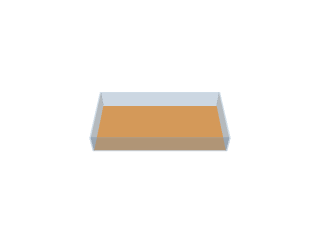

In [11]:
arena_configuration = AquariumArenaConfiguration(
        size=(10, 5), sand_ground_color=True, attach_target=False, wall_height=1.5, wall_thickness=0.1
        )
arena = create_arena(arena_configuration=arena_configuration)
visualize_mjcf(mjcf=arena)

## 3) creating an environment
Combining morphology and arena

The cell below just gives information about all the different environment configurations

In [12]:
from brb.brittle_star.environment.light.mjc_env import BrittleStarLightEnvironmentConfiguration
from brb.brittle_star.environment.target.mjc_env import BrittleStarTargetEnvironmentConfiguration
from brb.brittle_star.environment.locomotion.mjc_env import BrittleStarLocomotionEnvironmentConfiguration

locomotion_environment_configuration = BrittleStarLocomotionEnvironmentConfiguration(
         # If this value is > 0 then we will add randomly sampled noise to the initial joint positions and velocities 
        joint_randomization_noise_scale=0.0,
        # Visualization mode 
        render_mode="rgb_array",
        # Number of seconds per episode 
        simulation_time=5,
        # Number of physics substeps to do per control step 
        num_physics_steps_per_control_step=10
        )
target_locomotion_environment_configuration = BrittleStarTargetEnvironmentConfiguration(
        # Distance to put our target at (targets are spawned on a circle around the starting location with this given radius).
        target_distance=3.0,
        joint_randomization_noise_scale=0.0,
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10
        )
light_escape_environment_configuration = BrittleStarLightEnvironmentConfiguration(
        # If this value is > 0, we will add perlin noise to the generated light map. Otherwise, the light map is a simple linear gradient.
        #   Please only provide integer factors of 200.
        light_perlin_noise_scale=0,
        joint_randomization_noise_scale=0,
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10
        )

The below cell defines how to create an environment from the selected morphology specifications, aquarium configuration and the specific environment configuration, regarding light, target or distance as a reward.

In [13]:
from mujoco_utils.environment.mjc_env import MJCEnv
from brb.brittle_star.environment.light.mjc_env import BrittleStarLightMJCEnvironment
from brb.brittle_star.environment.target.mjc_env import BrittleStarTargetMJCEnvironment
from brb.brittle_star.environment.locomotion.mjc_env import BrittleStarLocomotionMJCEnvironment
from brb.brittle_star.environment.light.mjx_env import BrittleStarLightMJXEnvironment
from brb.brittle_star.environment.target.mjx_env import BrittleStarTargetMJXEnvironment
from brb.brittle_star.environment.locomotion.mjx_env import BrittleStarLocomotionMJXEnvironment
from mujoco_utils.environment.base import MuJoCoEnvironmentConfiguration


def create_environment(
        morphology_specification: BrittleStarMorphologySpecification,
        arena_configuration: AquariumArenaConfiguration,
        environment_configuration: MuJoCoEnvironmentConfiguration,
        backend: str,
        num_environments: int = 1
        ) -> Union[MJCEnv, MJXGymEnvWrapper]:
    assert backend in ["MJC", "MJX"], "Please specify a valid backend; Either 'MJC' or 'MJX'"

    def _create_env() -> Union[MJCEnv, gymnasium.vector.AsyncVectorEnv, MJXGymEnvWrapper]:
        morphology = create_morphology(
                morphology_specification=morphology_specification
                )
        arena = create_arena(
                arena_configuration=arena_configuration
                )
        if isinstance(environment_configuration, BrittleStarLocomotionEnvironmentConfiguration):
            env_class = BrittleStarLocomotionMJCEnvironment if backend == "MJC" else BrittleStarLocomotionMJXEnvironment
        elif isinstance(environment_configuration, BrittleStarTargetEnvironmentConfiguration):
            env_class = BrittleStarTargetMJCEnvironment if backend == "MJC" else BrittleStarTargetMJXEnvironment
        else:
            env_class = BrittleStarLightMJCEnvironment if backend == "MJC" else BrittleStarLightMJXEnvironment

        env = env_class(morphology=morphology, arena=arena, configuration=environment_configuration)
        return env

    if backend == "MJC":
        if num_environments > 1:
            return gymnasium.vector.AsyncVectorEnv(
                    [_create_env for _ in range(num_environments)]
                    )
        else:
            return _create_env()
    else:
        # MJXGymEnvWrapper takes care of the handling the consequences of functional programming made necessary by Jax 
        return MJXGymEnvWrapper(env=_create_env(), num_envs=num_environments)

Now we can start using these environments


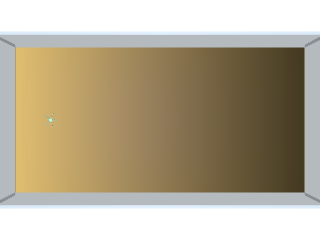

In [14]:
morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=4, use_p_control=True, use_torque_control=False
        )
arena_configuration = AquariumArenaConfiguration(
        size=(10, 5), sand_ground_color=True, attach_target=False, wall_height=1.5, wall_thickness=0.1
        )
environment_configuration = BrittleStarLightEnvironmentConfiguration(
        joint_randomization_noise_scale=0.0,
        light_perlin_noise_scale=0, # integer that divides 200
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10
        )

# arena_configuration = AquariumArenaConfiguration(
#         size=(10, 5), sand_ground_color=True, attach_target=True, wall_height=1.5, wall_thickness=0.1
#         )
# environment_configuration = BrittleStarTargetEnvironmentConfiguration(
#         # Distance to put our target at (targets are spawned on a circle around the starting location with this given radius).
#         target_distance=8.0,
#         joint_randomization_noise_scale=0.0,
#         render_mode="rgb_array",
#         simulation_time=5,
#         num_physics_steps_per_control_step=10
#         )


env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend="MJX"
        )

env.reset()  # Always need to reset the environment before doing anything else with it
frame = env.render()
media.show_image(post_environment_render(frame, environment_configuration=environment_configuration))
env.close() # always close the environment after using it!

In [15]:
mjc_env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend="MJC"
        )
mjx_env = create_environment(
        morphology_specification=morphology_specification,
        arena_configuration=arena_configuration,
        environment_configuration=environment_configuration,
        backend="MJX"
        )

In [16]:
print(mjc_env.observation_space)
print()
print(mjx_env.observation_space)

Dict('disk_angular_velocity': Box(-inf, inf, (3,), float32), 'disk_linear_velocity': Box(-inf, inf, (3,), float32), 'disk_position': Box(-inf, inf, (3,), float32), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), float32), 'in_plane_joint_position': Box(-0.5235988, 0.5235988, (20,), float32), 'in_plane_joint_velocity': Box(-inf, inf, (20,), float32), 'out_of_plane_joint_position': Box(-0.5235988, 0.5235988, (20,), float32), 'out_of_plane_joint_velocity': Box(-inf, inf, (20,), float32), 'segment_contact': Box(0.0, 1.0, (20,), float32), 'segment_light_intake': Box(0.0, 1.0, (20,), float32))

Dict('disk_angular_velocity': Box(-inf, inf, (3,), float32), 'disk_linear_velocity': Box(-inf, inf, (3,), float32), 'disk_position': Box(-inf, inf, (3,), float32), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), float32), 'in_plane_joint_position': Box(-0.5235988, 0.5235988, (20,), float32), 'in_plane_joint_velocity': Box(-inf, inf, (20,), float32), 'out_of_plane_joint_position': Box(-0.5235988, 0

In [17]:
print(mjc_env.action_space)
print()
print(mjx_env.action_space)

Box(-0.5235988, 0.5235988, (40,), float32)

Box(-0.5235988, 0.5235988, (40,), float32)


In [18]:
print(mjc_env.actuators[7:9])

['BrittleStarMorphology/arm_0_segment_3_out_of_plane_joint_p_control', 'BrittleStarMorphology/arm_1_segment_0_in_plane_joint_p_control']


In [19]:
done = False
frames = []
obs, info = mjx_env.reset()
while not done:
    actions = jnp.array(mjx_env.action_space.sample())
    obs, reward, terminated, truncated, info = mjx_env.step(actions=actions)
    frame = post_environment_render(mjx_env.render(), environment_configuration=environment_configuration)
    frames.append(frame)
    done = terminated | truncated
media.show_video(images=frames)

XlaRuntimeError: INTERNAL: cuSolver internal error

In [20]:
mjc_env.close()
mjx_env.close()

## Vectorization

In [ ]:
import time

start = time.time()

end = time.time()
print(end - start)